In [1]:
import sys
import docplex
import cplex
try:
    import docplex.mp
except:
    raise Exception('Please install docplex. See https://pypi.org/project/docplex/')      
    
from docplex.mp.environment import Environment
import numpy as np
from cplex.callbacks import MIPInfoCallback

import matplotlib.pyplot as plt
from tqdm import tqdm
from docplex.mp.model import Model
from math import floor, fabs

import cplex as CPX
import cplex.callbacks as CPX_CB

env = Environment()
env.print_information()

* system is: Windows 64bit
* Python version 3.7.6, located at: C:\Users\wz0622\anaconda37\python.exe
* docplex is present, version is 2.18.200
* CPLEX library is present, version is 20.1.0.0, located at: C:\Users\wz0622\anaconda37\lib\site-packages
* pandas is present, version is 1.0.1


# Experiment 1: Consumers and Facilities Experiment

In [78]:
global total
total = []

# Callback to count the number of nodes
class LoggingCallback(MIPInfoCallback):
    
    def __init__(self, *args, **kwargs):
        super(LoggingCallback, self).__init__(*args, **kwargs)

    def __call__(self):
        if self.get_num_remaining_nodes() == 0:
            total.append(self.get_num_nodes())
            
class CustomBranch(CPX_CB.BranchCallback):

    def __init__(self, *args, **kwargs):
        self.mu = 0.5
        super(CustomBranch, self).__init__(*args, **kwargs)

    def __call__(self):
        br_type = self.get_branch_type()
        if (br_type == self.branch_type.SOS1 or
                br_type == self.branch_type.SOS2):
            return

        x = self.get_values()

        objval = self.get_objective_value()
        obj = self.get_objective_coefficients()
        feas = self.get_feasibilities()

        maxobj = -CPX.infinity
        maxinf = -CPX.infinity
        bestj = -1

        for j in range(len(x)):
            obj_plus = 0
            obj_minus = 0
            if feas[j] == self.feasibility_status.infeasible:
                for k in range(len(x)):
                    if k == j:
                        obj_plus += obj[j]
                        obj_minus += 0
                    else:
                        obj_plus += x[k]*obj[k]
                        obj_minus += x[k]*obj[k]
                score_1 = min(objval-obj_plus, objval-obj_minus)
                score_2 = max(objval-obj_plus, objval-obj_minus)

                frac = self.mu*score_1 + (1-self.mu)*score_2
                if (frac >= maxinf and
                        (frac > maxinf or fabs(obj[j]) >= maxobj)):
                    bestj = j
                    maxinf = frac
                    maxobj = fabs(obj[j])

        if bestj < 0:
            return

        xj_lo = floor(x[bestj])
        self.make_branch(objval, variables=[(bestj, "L", xj_lo + 1)],
                         node_data=(bestj, xj_lo, "UP"))
        self.make_branch(objval, variables=[(bestj, "U", xj_lo)],
                         node_data=(bestj, xj_lo, "DOWN"))

## Testing Single MILP

In [171]:
# Setting up the problem
nb_consumers = 30
nb_facilities = 30

distances = np.random.randint(0,10000, size=(nb_consumers,nb_facilities))
costs = np.random.randint(0,3000, size=(nb_facilities))

loads = []
for i in range(nb_facilities):
    if costs[i]>1000 and costs[i]<2000:
        loads.append(np.random.randint(2,4))
    elif costs[i]>=2000 and costs[i]<=3000:
        loads.append(np.random.randint(4,6))
    else:
        loads.append(np.random.randint(1,3))

In [182]:
class LinearBranch(CPX_CB.BranchCallback):

    def __init__(self, *args, **kwargs):
        self.mu = 0
        super(LinearBranch, self).__init__(*args, **kwargs)

    def __call__(self):
        br_type = self.get_branch_type()
        if (br_type == self.branch_type.SOS1 or
                br_type == self.branch_type.SOS2):
            return

        x = self.get_values()

        objval = self.get_objective_value()
        obj = self.get_objective_coefficients()
        feas = self.get_feasibilities()

        maxobj = -CPX.infinity
        maxinf = -CPX.infinity
        bestj = -1

        for j in range(len(x)):
            obj_plus = 0
            obj_minus = 0
            if feas[j] == self.feasibility_status.infeasible:
                for k in range(len(x)):
                    if k == j:
                        obj_plus += obj[j]
                        obj_minus += 0
                    else:
                        obj_plus += x[k]*obj[k]
                        obj_minus += x[k]*obj[k]
                score_1 = min(objval-obj_plus, objval-obj_minus)
                score_2 = max(objval-obj_plus, objval-obj_minus)

                frac = self.mu*score_1 + (1-self.mu)*score_2
                if (frac >= maxinf and
                        (frac > maxinf or fabs(obj[j]) >= maxobj)):
                    bestj = j
                    maxinf = frac
                    maxobj = fabs(obj[j])

        if bestj < 0:
            return

        xj_lo = floor(x[bestj])
        # the (bestj, xj_lo, direction) triple can be any python object to
        # associate with a node
        self.make_branch(objval, variables=[(bestj, "L", xj_lo + 1)],
                         node_data=(bestj, xj_lo, "UP"))
        self.make_branch(objval, variables=[(bestj, "U", xj_lo)],
                         node_data=(bestj, xj_lo, "DOWN"))

mdl = Model()


# Disabling Heuristics
mdl.parameters.mip.strategy.heuristicfreq.set(-1)
mdl.parameters.mip.strategy.rinsheur.set(-1)
mdl.parameters.mip.strategy.fpheur.set(-1)
mdl.parameters.mip.strategy.lbheur.set(0)

# Disabling Preprocessing
mdl.parameters.preprocessing.relax.set(0)
mdl.parameters.preprocessing.repeatpresolve(0)
mdl.parameters.preprocessing.numpass(0)
mdl.parameters.preprocessing.reduce(0)

# Disabling Cut Ability
mdl.parameters.mip.cuts.bqp.set(-1)
mdl.parameters.mip.cuts.cliques.set(-1)
mdl.parameters.mip.cuts.covers.set(-1)
mdl.parameters.mip.cuts.disjunctive.set(-1)
mdl.parameters.mip.cuts.flowcovers.set(-1)
mdl.parameters.mip.cuts.pathcut.set(-1)
mdl.parameters.mip.cuts.gomory.set(-1)

mdl.parameters.mip.cuts.gubcovers.set(-1)
mdl.parameters.mip.cuts.implied.set(-1)
mdl.parameters.mip.cuts.localimplied.set(-1)
mdl.parameters.mip.cuts.liftproj.set(-1)
mdl.parameters.mip.cuts.mircut.set(-1)
mdl.parameters.mip.cuts.mcfcut.set(-1)
mdl.parameters.mip.cuts.rlt.set(-1)
mdl.parameters.mip.cuts.zerohalfcut.set(-1)

#Cut Passes
mdl.parameters.mip.limits.cutpasses(-1)

# Single Thread
mdl.parameters.threads.set(1)

variables = mdl.integer_var_list(nb_facilities, lb=0, ub=1)

y = mdl.continuous_var_matrix(nb_consumers, nb_facilities, lb=0, ub=1)

mdl.minimize(mdl.sum(costs[i]*variables[i] for i in range(nb_facilities)) + mdl.sum(mdl.sum(y[i,j]*distances[i,j] for j in range(nb_facilities)) for i in range(nb_consumers)))

for i in range(nb_consumers):
    mdl.add_constraint(mdl.sum(y[i,j] for j in range(nb_facilities)) == 1)
    
for i in range(nb_facilities):
    mdl.add_constraint(mdl.sum(y[j,i] for j in range(nb_consumers)) <= loads[i])

for i in range(nb_consumers):
    for j in range(nb_facilities):
        mdl.add_constraint(y[i,j] <= variables[j])

mdl.register_callback(LoggingCallback)
mdl.register_callback(LinearBranch)

output = mdl.solve(log_output = True);

Version identifier: 20.1.0.0 | 2020-11-10 | 9bedb6d68
CPXPARAM_Preprocessing_NumPass                   0
CPXPARAM_Read_DataCheck                          1
CPXPARAM_Preprocessing_Reduce                    0
CPXPARAM_Threads                                 1
CPXPARAM_RandomSeed                              202001241
CPXPARAM_MIP_Cuts_Cliques                        -1
CPXPARAM_MIP_Cuts_Covers                         -1
CPXPARAM_Preprocessing_Relax                     0
CPXPARAM_MIP_Cuts_FlowCovers                     -1
CPXPARAM_MIP_Cuts_Implied                        -1
CPXPARAM_MIP_Cuts_GUBCovers                      -1
CPXPARAM_MIP_Cuts_Gomory                         -1
CPXPARAM_MIP_Cuts_PathCut                        -1
CPXPARAM_MIP_Cuts_MIRCut                         -1
CPXPARAM_MIP_Cuts_Disjunctive                    -1
CPXPARAM_Preprocessing_RepeatPresolve            0
CPXPARAM_MIP_Strategy_FPHeur                     -1
CPXPARAM_MIP_Cuts_ZeroHalfCut                    -1
CPXPARAM_

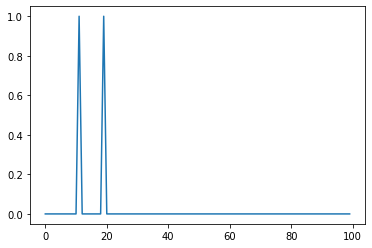

In [211]:
plt.plot([output.get_var_value(variables[i]) for i in range(len(variables))])

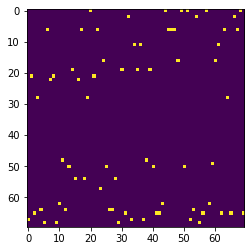

In [114]:
plt.imshow(np.array([[output.get_var_value(y[i,j]) for i in range(nb_consumers)] for j in range(nb_facilities)]))

## Running Experiments

In [187]:
exp1_all_runs = []
experiments = 200
for ex in tqdm(range(experiments)):
    
    # Setting up the problem
    nb_consumers = 30
    nb_facilities = 30
    distances = np.random.randint(0,10000, size=(nb_consumers,nb_facilities))
    costs = np.random.randint(0,3000, size=(nb_facilities))

    loads = []
    for i in range(nb_facilities):
        if costs[i]>1000 and costs[i]<2000:
            loads.append(np.random.randint(2,4))
        elif costs[i]>=2000 and costs[i]<=3000:
            loads.append(np.random.randint(4,6))
        else:
            loads.append(np.random.randint(1,3))
    
    # Discretization Step
    total_iterations = 100
    total = []

    for index in range(total_iterations):

        class LinearBranch(CPX_CB.BranchCallback):

            def __init__(self, *args, **kwargs):
                self.mu = np.linspace(0,1,total_iterations)[index]
                super(LinearBranch, self).__init__(*args, **kwargs)

            def __call__(self):
                br_type = self.get_branch_type()
                if (br_type == self.branch_type.SOS1 or
                        br_type == self.branch_type.SOS2):
                    return

                x = self.get_values()

                objval = self.get_objective_value()
                obj = self.get_objective_coefficients()
                feas = self.get_feasibilities()

                maxobj = -CPX.infinity
                maxinf = -CPX.infinity
                bestj = -1

                for j in range(len(x)):
                    obj_plus = 0
                    obj_minus = 0
                    if feas[j] == self.feasibility_status.infeasible:
                        for k in range(len(x)):
                            if k == j:
                                obj_plus += obj[j]
                                obj_minus += 0
                            else:
                                obj_plus += x[k]*obj[k]
                                obj_minus += x[k]*obj[k]
                        score_1 = min(objval-obj_plus, objval-obj_minus)
                        score_2 = max(objval-obj_plus, objval-obj_minus)

                        frac = self.mu*score_1 + (1-self.mu)*score_2
                        if (frac >= maxinf and
                                (frac > maxinf or fabs(obj[j]) >= maxobj)):
                            bestj = j
                            maxinf = frac
                            maxobj = fabs(obj[j])

                if bestj < 0:
                    return

                xj_lo = floor(x[bestj])
                # the (bestj, xj_lo, direction) triple can be any python object to
                # associate with a node
                self.make_branch(objval, variables=[(bestj, "L", xj_lo + 1)],
                                 node_data=(bestj, xj_lo, "UP"))
                self.make_branch(objval, variables=[(bestj, "U", xj_lo)],
                                 node_data=(bestj, xj_lo, "DOWN"))

        mdl = Model()


        # Disabling Heuristics
        mdl.parameters.mip.strategy.heuristicfreq.set(-1)
        mdl.parameters.mip.strategy.rinsheur.set(-1)
        mdl.parameters.mip.strategy.fpheur.set(-1)
        mdl.parameters.mip.strategy.lbheur.set(0)

        # Disabling Preprocessing
        mdl.parameters.preprocessing.relax.set(0)
        mdl.parameters.preprocessing.repeatpresolve(0)
        mdl.parameters.preprocessing.numpass(0)
        mdl.parameters.preprocessing.reduce(0)

        # Disabling Cut Ability
        mdl.parameters.mip.cuts.bqp.set(-1)
        mdl.parameters.mip.cuts.cliques.set(-1)
        mdl.parameters.mip.cuts.covers.set(-1)
        mdl.parameters.mip.cuts.disjunctive.set(-1)
        mdl.parameters.mip.cuts.flowcovers.set(-1)
        mdl.parameters.mip.cuts.pathcut.set(-1)
        mdl.parameters.mip.cuts.gomory.set(-1)

        mdl.parameters.mip.cuts.gubcovers.set(-1)
        mdl.parameters.mip.cuts.implied.set(-1)
        mdl.parameters.mip.cuts.localimplied.set(-1)
        mdl.parameters.mip.cuts.liftproj.set(-1)
        mdl.parameters.mip.cuts.mircut.set(-1)
        mdl.parameters.mip.cuts.mcfcut.set(-1)
        mdl.parameters.mip.cuts.rlt.set(-1)
        mdl.parameters.mip.cuts.zerohalfcut.set(-1)

        #Cut Passes
        mdl.parameters.mip.limits.cutpasses(-1)

        # Single Thread
        mdl.parameters.threads.set(1)

        variables = mdl.integer_var_list(nb_facilities, lb=0, ub=1)

        y = mdl.continuous_var_matrix(nb_consumers, nb_facilities, lb=0, ub=1)

        mdl.minimize(mdl.sum(costs[i]*variables[i] for i in range(nb_facilities)) + mdl.sum(mdl.sum(y[i,j]*distances[i,j] for j in range(nb_facilities)) for i in range(nb_consumers)))

        for i in range(nb_consumers):
            mdl.add_constraint(mdl.sum(y[i,j] for j in range(nb_facilities)) == 1)

        for i in range(nb_consumers):
            for j in range(nb_facilities):
                mdl.add_constraint(y[i,j] <= variables[j])
                
        for i in range(nb_facilities):
            mdl.add_constraint(mdl.sum(y[j,i] for j in range(nb_consumers)) <= loads[i])

        mdl.register_callback(LoggingCallback)
        mdl.register_callback(LinearBranch)

        output = mdl.solve();
    
    exp1_all_runs.append(total[::2].copy())




  0%|                                                                                          | 0/200 [00:00<?, ?it/s]


  0%|▍                                                                               | 1/200 [00:25<1:24:43, 25.55s/it]


  1%|▊                                                                               | 2/200 [01:20<1:53:25, 34.37s/it]


  2%|█▏                                                                              | 3/200 [01:52<1:50:47, 33.74s/it]


  2%|█▌                                                                              | 4/200 [01:59<1:23:35, 25.59s/it]


  2%|██                                                                              | 5/200 [02:59<1:56:52, 35.96s/it]


  3%|██▍                                                                             | 6/200 [03:43<2:04:17, 38.44s/it]


  4%|██▊                                                                             | 7/200 [04:02<1:44:40, 32.54s/it]


  4%|███▏            

 31%|████████████████████████▍                                                      | 62/200 [58:24<2:17:47, 59.91s/it]


 32%|████████████████████████▉                                                      | 63/200 [59:02<2:01:33, 53.23s/it]


 32%|█████████████████████████▎                                                     | 64/200 [59:20<1:36:48, 42.71s/it]


 32%|█████████████████████████▋                                                     | 65/200 [59:41<1:21:13, 36.10s/it]


 33%|█████████████████████████▍                                                   | 66/200 [1:00:24<1:25:36, 38.33s/it]


 34%|█████████████████████████▊                                                   | 67/200 [1:00:33<1:05:26, 29.52s/it]


 34%|██████████████████████████▊                                                    | 68/200 [1:00:53<58:20, 26.52s/it]


 34%|███████████████████████████▎                                                   | 69/200 [1:01:14<54:29, 24.96s/it]


 35%|███████████████████

 62%|███████████████████████████████████████████████                             | 124/200 [1:50:43<1:16:26, 60.35s/it]


 62%|███████████████████████████████████████████████▌                            | 125/200 [1:51:19<1:06:21, 53.08s/it]


 63%|█████████████████████████████████████████████████▏                            | 126/200 [1:51:38<52:50, 42.84s/it]


 64%|████████████████████████████████████████████████▎                           | 127/200 [1:52:45<1:00:55, 50.07s/it]


 64%|█████████████████████████████████████████████████▉                            | 128/200 [1:53:23<55:45, 46.47s/it]


 64%|██████████████████████████████████████████████████▎                           | 129/200 [1:53:38<43:57, 37.15s/it]


 65%|██████████████████████████████████████████████████▋                           | 130/200 [1:55:01<59:21, 50.88s/it]


 66%|█████████████████████████████████████████████████▊                          | 131/200 [1:56:30<1:11:37, 62.28s/it]


 66%|███████████████████

 93%|███████████████████████████████████████████████████████████████████████▌     | 186/200 [2:48:06<23:37, 101.26s/it]


 94%|████████████████████████████████████████████████████████████████████████▉     | 187/200 [2:48:18<16:08, 74.47s/it]


 94%|█████████████████████████████████████████████████████████████████████████▎    | 188/200 [2:48:29<11:03, 55.32s/it]


 94%|█████████████████████████████████████████████████████████████████████████▋    | 189/200 [2:48:52<08:22, 45.66s/it]


 95%|██████████████████████████████████████████████████████████████████████████    | 190/200 [2:49:02<05:51, 35.12s/it]


 96%|██████████████████████████████████████████████████████████████████████████▍   | 191/200 [2:49:16<04:18, 28.70s/it]


 96%|██████████████████████████████████████████████████████████████████████████▉   | 192/200 [2:49:35<03:25, 25.67s/it]


 96%|███████████████████████████████████████████████████████████████████████████▎  | 193/200 [2:49:47<02:32, 21.80s/it]


 97%|███████████████████

In [192]:
for i in exp1_all_runs:
    print(len(i))

100
74
100
0
82
98
100
100
69
89
100
96
79
57
45
100
88
96
89
100
100
75
100
95
100
82
92
100
100
97
64
100
100
100
48
91
74
100
100
81
98
100
100
91
100
100
100
89
100
100
100
100
0
100
100
81
69
100
100
100
63
100
95
100
100
88
100
76
100
50
90
100
94
100
77
100
100
99
100
100
99
100
92
92
97
100
67
99
100
96
82
87
100
100
89
100
100
57
100
92
99
100
100
90
90
82
100
77
100
100
87
100
79
100
91
86
100
100
82
91
77
100
100
93
100
93
72
84
100
100
83
71
100
98
100
100
100
75
100
78
57
100
100
94
100
68
100
99
100
85
100
98
100
91
100
91
75
100
100
100
100
89
84
99
85
96
100
100
100
92
100
89
100
50
95
92
100
98
100
85
100
62
96
98
57
99
100
100
100
100
100
100
100
96
100
100
94
100
100
100


In [194]:
filtered_exp1_all_runs = []
for i in exp1_all_runs:
    if len(i) == 100:
        filtered_exp1_all_runs.append(i)

In [196]:
filtered_exp1_all_runs = np.array(filtered_exp1_all_runs)

In [208]:
max_filtered_normalized_all_runs = []
for i in range(len(all_runs)):
    if np.max(filtered_exp1_all_runs[i])<300:
        max_filtered_normalized_all_runs.append(filtered_exp1_all_runs[i]/np.max(filtered_exp1_all_runs[i]))
max_filtered_normalized_all_runs = np.array(max_filtered_normalized_all_runs)

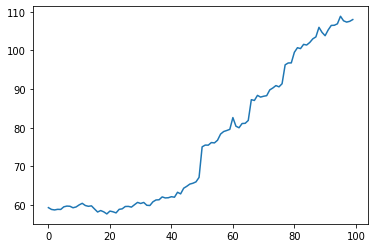

In [198]:
plt.plot(filtered_exp1_all_runs.mean(axis=0))

Text(0.5, 1.0, 'Max-Normalized Node Count vs $\\mu$')

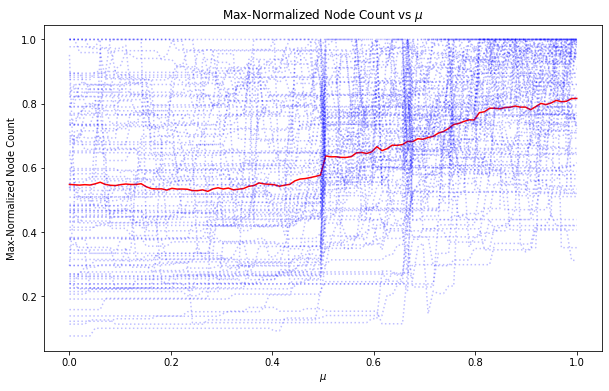

In [210]:
plt.figure(figsize=(10,6))

plt.plot(np.linspace(0,1,100), max_filtered_normalized_all_runs.mean(axis=0), c='r')
plt.plot(np.linspace(0,1,100), max_filtered_normalized_all_runs.T, alpha=0.25, linestyle='dotted', c='b')
plt.xlabel(r"$\mu$")
plt.ylabel("Max-Normalized Node Count")
plt.title(r"Max-Normalized Node Count vs $\mu$")

# plt.plot(all_runs.mean(axis=0), c='r')
# plt.plot(all_runs.T, alpha=0.5, linestyle='dotted')

# Experiment 2: Random MILP Solving

In [ ]:
lower_coef = 0
higher_coef = 20
n = 50
m = 100

coefficients = np.random.randint(lower_coef,higher_coef, size=(n,m))
RHS = np.random.randint(28,50,size=(n))
optimization_coefficients = np.random.randint(1,5,size=m)

In [188]:
# Example Callback Function
global total

# Callback to count the number of nodes
class LoggingCallback(MIPInfoCallback):
    
    def __init__(self, *args, **kwargs):
        super(LoggingCallback, self).__init__(*args, **kwargs)

    def __call__(self):
        if self.get_num_remaining_nodes() == 0:
            total.append(self.get_num_nodes())

class MyBranch(CPX_CB.BranchCallback):
    def __call__(self):
        print(self.get_num_remaining_nodes())
        if self.get_num_remaining_nodes() == 0:
            print(self.get_num_nodes())
            c_coef = self.get_objective_coefficients()
            print(c_coef)

all_runs = []
experiments = 200
for ex in tqdm(range(experiments)):
    
    # Initializing Experiment
    lower_coef = 0
    higher_coef = 20
    n = 50
    m = 100

    coefficients = np.random.randint(lower_coef,higher_coef, size=(n,m))
    RHS = np.random.randint(28,50,size=(n))
    optimization_coefficients = np.random.randint(1,5,size=m)
    
    # Discretization Step
    total_iterations = 100
    total = []

    for index in range(total_iterations):

        class LinearBranch(CPX_CB.BranchCallback):

            def __init__(self, *args, **kwargs):
                self.mu = np.linspace(0,1,total_iterations)[index]
                super(LinearBranch, self).__init__(*args, **kwargs)

            def __call__(self):
                br_type = self.get_branch_type()
                if (br_type == self.branch_type.SOS1 or
                        br_type == self.branch_type.SOS2):
                    return

                x = self.get_values()

                objval = self.get_objective_value()
                obj = self.get_objective_coefficients()
                feas = self.get_feasibilities()

                maxobj = -CPX.infinity
                maxinf = -CPX.infinity
                bestj = -1

                for j in range(len(x)):
                    obj_plus = 0
                    obj_minus = 0
                    if feas[j] == self.feasibility_status.infeasible:
                        for k in range(len(x)):
                            if k == j:
                                obj_plus += obj[j]
                                obj_minus += 0
                            else:
                                obj_plus += x[k]*obj[k]
                                obj_minus += x[k]*obj[k]
                        score_1 = min(objval-obj_plus, objval-obj_minus)
                        score_2 = max(objval-obj_plus, objval-obj_minus)

                        frac = self.mu*score_1 + (1-self.mu)*score_2
                        if (frac >= maxinf and
                                (frac > maxinf or fabs(obj[j]) >= maxobj)):
                            bestj = j
                            maxinf = frac
                            maxobj = fabs(obj[j])

                if bestj < 0:
                    return

                xj_lo = floor(x[bestj])
                # the (bestj, xj_lo, direction) triple can be any python object to
                # associate with a node
                self.make_branch(objval, variables=[(bestj, "L", xj_lo + 1)],
                                 node_data=(bestj, xj_lo, "UP"))
                self.make_branch(objval, variables=[(bestj, "U", xj_lo)],
                                 node_data=(bestj, xj_lo, "DOWN"))




        bbm = Model(name='b&b')

        # Disabling Heuristics
        mdl.parameters.mip.strategy.heuristicfreq.set(-1)
        mdl.parameters.mip.strategy.rinsheur.set(-1)
        mdl.parameters.mip.strategy.fpheur.set(-1)
        mdl.parameters.mip.strategy.lbheur.set(0)

        # Disabling Preprocessing
        mdl.parameters.preprocessing.relax.set(0)
        mdl.parameters.preprocessing.repeatpresolve(0)
        mdl.parameters.preprocessing.numpass(0)
        mdl.parameters.preprocessing.reduce(0)

        # Disabling Cut Ability
        mdl.parameters.mip.cuts.bqp.set(-1)
        mdl.parameters.mip.cuts.cliques.set(-1)
        mdl.parameters.mip.cuts.covers.set(-1)
        mdl.parameters.mip.cuts.disjunctive.set(-1)
        mdl.parameters.mip.cuts.flowcovers.set(-1)
        mdl.parameters.mip.cuts.pathcut.set(-1)
        mdl.parameters.mip.cuts.gomory.set(-1)

        mdl.parameters.mip.cuts.gubcovers.set(-1)
        mdl.parameters.mip.cuts.implied.set(-1)
        mdl.parameters.mip.cuts.localimplied.set(-1)
        mdl.parameters.mip.cuts.liftproj.set(-1)
        mdl.parameters.mip.cuts.mircut.set(-1)
        mdl.parameters.mip.cuts.mcfcut.set(-1)
        mdl.parameters.mip.cuts.rlt.set(-1)
        mdl.parameters.mip.cuts.zerohalfcut.set(-1)

        #Cut Passes
        mdl.parameters.mip.limits.cutpasses(-1)

        # Single Thread
        mdl.parameters.threads.set(1)

        # Adding a callback
        bbm.register_callback(LoggingCallback)
        bbm.register_callback(LinearBranch)

        variables = bbm.integer_var_list(m, lb=0, ub=1)

        bbm.maximize(bbm.sum(optimization_coefficients[i]*variables[i] for i in range(m)))

        for i in range(n):
            bbm.add_constraint(bbm.sum(coefficients[i,j]*variables[j] for j in range(m)) <= RHS[i])

        output = bbm.solve();
        
    all_runs.append(total[::2].copy())




  0%|                                                                                          | 0/200 [00:00<?, ?it/s]

AttributeError: 'numpy.ndarray' object has no attribute 'append'

In [99]:
all_runs = np.array(all_runs)

In [100]:
all_runs.shape

(100, 100)

In [101]:
max_normalized_all_runs = []
for i in range(len(all_runs)):
    max_normalized_all_runs.append(all_runs[i]/np.max(all_runs[i]))
max_normalized_all_runs = np.array(max_normalized_all_runs)

Text(0.5, 1.0, 'Max-Normalized Node Count vs $\\mu$')

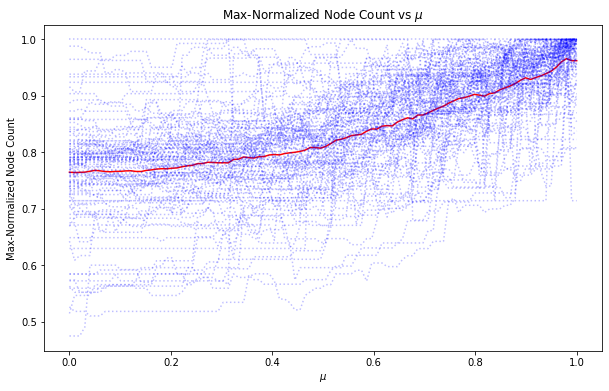

In [199]:
plt.figure(figsize=(10,6))

plt.plot(np.linspace(0,1,100),max_normalized_all_runs.mean(axis=0), c='r')
plt.plot(np.linspace(0,1,100),max_normalized_all_runs.T, alpha=0.25, linestyle='dotted', c='b')
plt.xlabel(r"$\mu$")
plt.ylabel("Max-Normalized Node Count")
plt.title(r"Max-Normalized Node Count vs $\mu$")

# plt.plot(all_runs.mean(axis=0), c='r')
# plt.plot(all_runs.T, alpha=0.5, linestyle='dotted')

Text(0.5, 1.0, 'Max-Normalized Node Count vs $\\mu$')

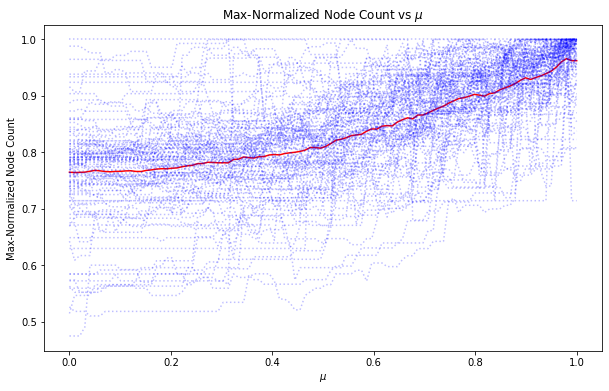

In [204]:
plt.figure(figsize=(10,6))

plt.plot(np.linspace(0,1,100),max_normalized_all_runs.mean(axis=0), c='r')
plt.plot(np.linspace(0,1,100),max_normalized_all_runs.T, alpha=0.25, linestyle='dotted', c='b')
plt.xlabel(r"$\mu$")
plt.ylabel("Max-Normalized Node Count")
plt.title(r"Max-Normalized Node Count vs $\mu$")

# plt.plot(all_runs.mean(axis=0), c='r')
# plt.plot(all_runs.T, alpha=0.5, linestyle='dotted')